## Time series analysis for average bike trafic prediction in Paris and Rennes

The purpose is to forecast bike traffic in Paris and Rennes for 2023 for the metropoles to define the bike infrastructures creation plan.

In [46]:
# Libraries

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split, KFold # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learning:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

Starting with Rennes as we have a lot more data (start in 2014 vs Paris in 2021).

First step : train with data from 2014 to 2021 and validation data for 2022.

In [100]:
# Load data

comptages_rennes = './datasets/comptages_journaliers_rennes.csv'

with open(comptages_rennes, 'r') as rennes:
    df_comptage_rennes = pd.read_csv(rennes)

df_comptage_rennes.drop([0,1], axis=0, inplace=True)
df_comptage_rennes.rename(columns={'Unnamed: 0':'date', 'name':'measure_points', 'counts':'bike_count'}, inplace=True)
df_comptage_rennes['measure_points'] = pd.to_numeric(df_comptage_rennes['measure_points'])
df_comptage_rennes['bike_count'] = pd.to_numeric(df_comptage_rennes['bike_count'])
df_comptage_rennes['date'] = pd.to_datetime(df_comptage_rennes['date'])
df_comptage_rennes['date'] = pd.to_numeric(df_comptage_rennes['date'])
df_comptage_rennes['weighted_bc'] = df_comptage_rennes['bike_count'] / df_comptage_rennes['measure_points']
#df_comptage_rennes.set_index('date', inplace=True)
df_comptage_rennes.head()

,date,measure_points,bike_count,weighted_bc
2,1415232000000000000,1,231.0,231.0
3,1415318400000000000,1,310.0,310.0
4,1415404800000000000,1,211.0,211.0
5,1415491200000000000,1,162.0,162.0
6,1415577600000000000,1,288.0,288.0


In [32]:
df_comptage_rennes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979 entries, 2 to 2980
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2979 non-null   datetime64[ns]
 1   measure_points  2979 non-null   int64         
 2   bike_count      2979 non-null   float64       
 3   weighted_bc     2979 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 93.2 KB


In [34]:
df_comptage_rennes.describe(include='all', datetime_is_numeric=True)

,date,measure_points,bike_count,weighted_bc
count,2979,2979.000000,2979.000000,2979.000000
mean,2018-12-09 14:27:40.422960640,1.470292,1682.079557,986.922793
min,2014-11-06 00:00:00,1.000000,0.000000,0.000000
25%,2016-11-19 12:00:00,1.000000,317.000000,314.000000
50%,2018-12-14 00:00:00,1.000000,1321.000000,774.000000
75%,2020-12-27 12:00:00,2.000000,2899.000000,1623.000000
max,2023-01-11 00:00:00,2.000000,5342.000000,3080.000000
std,NaN,0.499200,1487.065450,750.317658


In [20]:
df_comptage_rennes.isnull().sum()

date              0
measure_points    0
bike_count        0
weighted_bc       0
dtype: int64

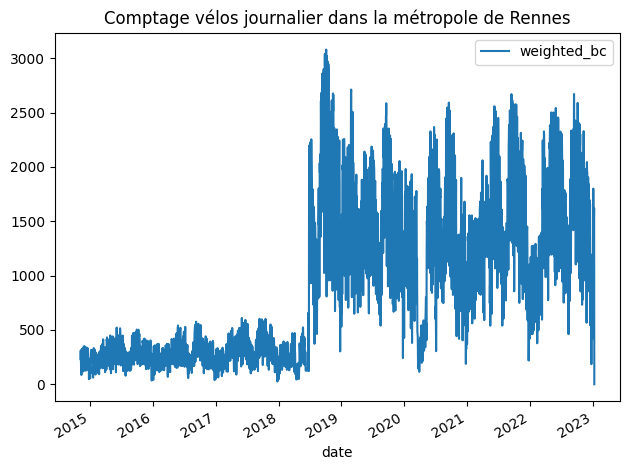

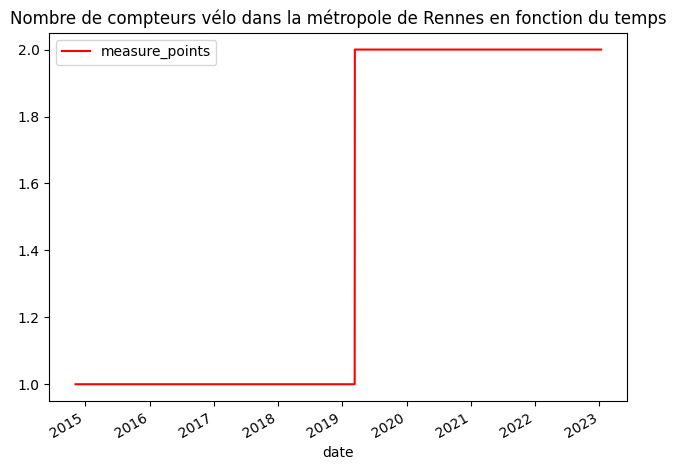

In [40]:
df_comptage_rennes.plot(x='date', y='weighted_bc', title='Comptage vélos journalier dans la métropole de Rennes')
plt.tight_layout()
plt.show()

df_comptage_rennes.plot(x='date', y='measure_points', title='Nombre de compteurs vélo dans la métropole de Rennes en fonction du temps', color='red')
plt.tight_layout()
plt.show();

            measure_points  bike_count  weighted_bc
date                                               
2021-11-29               2         0.0     0.000000
2021-12-01              65    149322.0  2297.261538
2021-12-02              65    173378.0  2667.353846
2021-12-03              65    109700.0  1687.692308
2021-12-04              65     80708.0  1241.661538


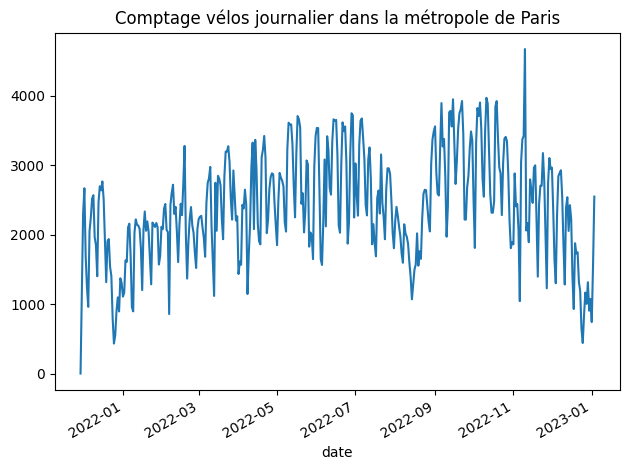

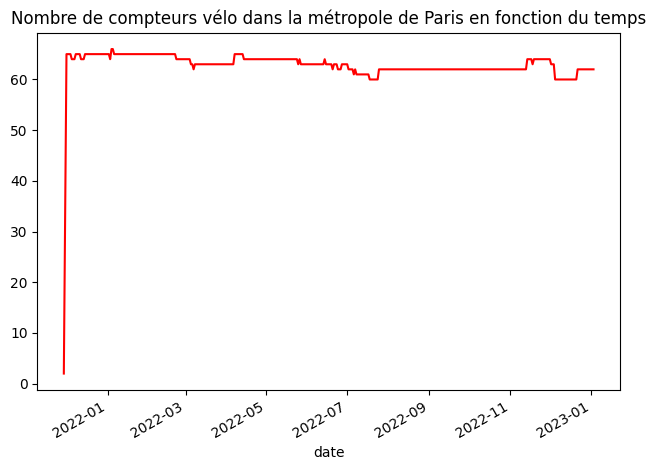

In [55]:
# Load data

comptages_paris = './datasets/comptages_journaliers_paris.csv'

with open(comptages_paris, 'r') as paris:
    df_comptage_paris = pd.read_csv(paris)

df_comptage_paris.drop([0, 1], axis=0, inplace=True)
df_comptage_paris.rename(columns={'Unnamed: 0':'date', 'name':'measure_points', 'sum_counts':'bike_count'}, inplace=True)
df_comptage_paris['measure_points'] = pd.to_numeric(df_comptage_paris['measure_points'])
df_comptage_paris['bike_count'] = pd.to_numeric(df_comptage_paris['bike_count'])
df_comptage_paris['date'] = pd.to_datetime(df_comptage_paris['date'])
df_comptage_paris['weighted_bc'] = df_comptage_paris['bike_count'] / df_comptage_paris['measure_points']
df_comptage_paris.set_index('date', inplace=True)
print(df_comptage_paris.head())

df_comptage_paris['weighted_bc'].plot(title='Comptage vélos journalier dans la métropole de Paris')
plt.tight_layout()
plt.show()

df_comptage_paris['measure_points'].plot(title='Nombre de compteurs vélo dans la métropole de Paris en fonction du temps', color='red')
plt.tight_layout()
plt.show();

In [56]:
df_comptage_paris.shape

(400, 3)

In [115]:
values = df_comptage_rennes.values

n_train_time = 365*2

train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 


(730, 1, 3) (730,) (2249, 1, 3) (2249,)


Epoch 1/1000
11/11 [==============================] - 3s 70ms/step - loss: 97571.4219 - val_loss: 2005041.1250
Epoch 2/1000
11/11 [==============================] - 0s 18ms/step - loss: 97396.4141 - val_loss: 2004345.5000
Epoch 3/1000
11/11 [==============================] - 0s 15ms/step - loss: 97231.8906 - val_loss: 2003651.3750
Epoch 4/1000
11/11 [==============================] - 0s 17ms/step - loss: 97066.0156 - val_loss: 2002958.3750
Epoch 5/1000
11/11 [==============================] - 0s 19ms/step - loss: 96909.0312 - val_loss: 2002267.0000
Epoch 6/1000
11/11 [==============================] - 0s 19ms/step - loss: 96732.2188 - val_loss: 2001577.8750
Epoch 7/1000
11/11 [==============================] - 0s 20ms/step - loss: 96570.3438 - val_loss: 2000887.7500
Epoch 8/1000
11/11 [==============================] - 0s 24ms/step - loss: 96387.6406 - val_loss: 2000198.0000
Epoch 9/1000
11/11 [==============================] - 0s 21ms/step - loss: 96229.8203 - val_loss: 1999511.1250
E

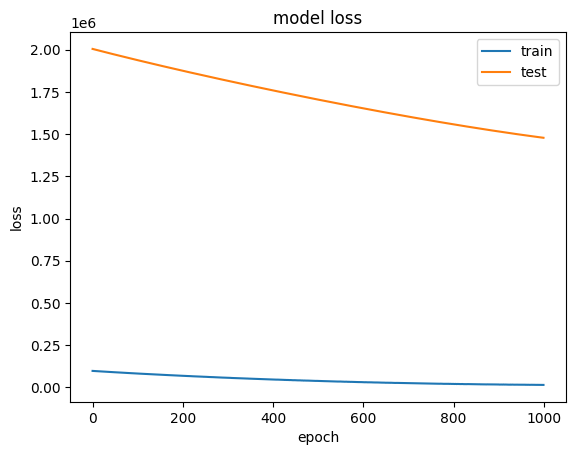

71/71 [==============================] - 1s 2ms/step
[[240.58911]
 [240.58911]
 [240.58911]
 ...
 [240.58911]
 [240.58911]
 [240.58911]]
Test RMSE: 1215.993


In [116]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=70, validation_data=(test_X, test_y), shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
print(yhat)
test_X = test_X.reshape((test_X.shape[0], 3))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

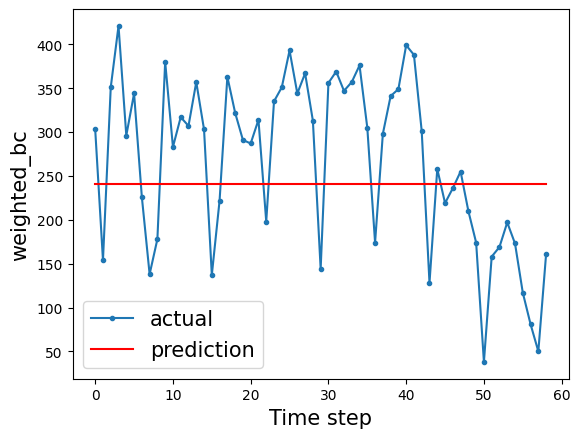

In [117]:
aa=[x for x in range(59)]
plt.plot(aa, inv_y[:59], marker='.', label="actual")
plt.plot(aa, inv_yhat[:59], 'r', label="prediction")
plt.ylabel('weighted_bc', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()